# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# convert data for matlab     
# import numpy, scipy.io
# scipy.io.savemat('traffic-signs-data/train.mat', mdict={'train': train})
# scipy.io.savemat('traffic-signs-data/test.mat', mdict={'test': test})

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
import numpy as np
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))
print(len(np.unique(y_train)))

(39209, 32, 32, 3)
(12630, 32, 32, 3)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
43


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = 39209

# TODO: Number of testing examples.
n_test = 12630

# TODO: What's the shape of an traffic sign image?
image_shape = (32,32,3)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

0


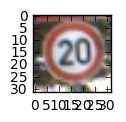

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# visualize 1 random traffic sign
index = random.randint(0, len(X_train)-1)
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

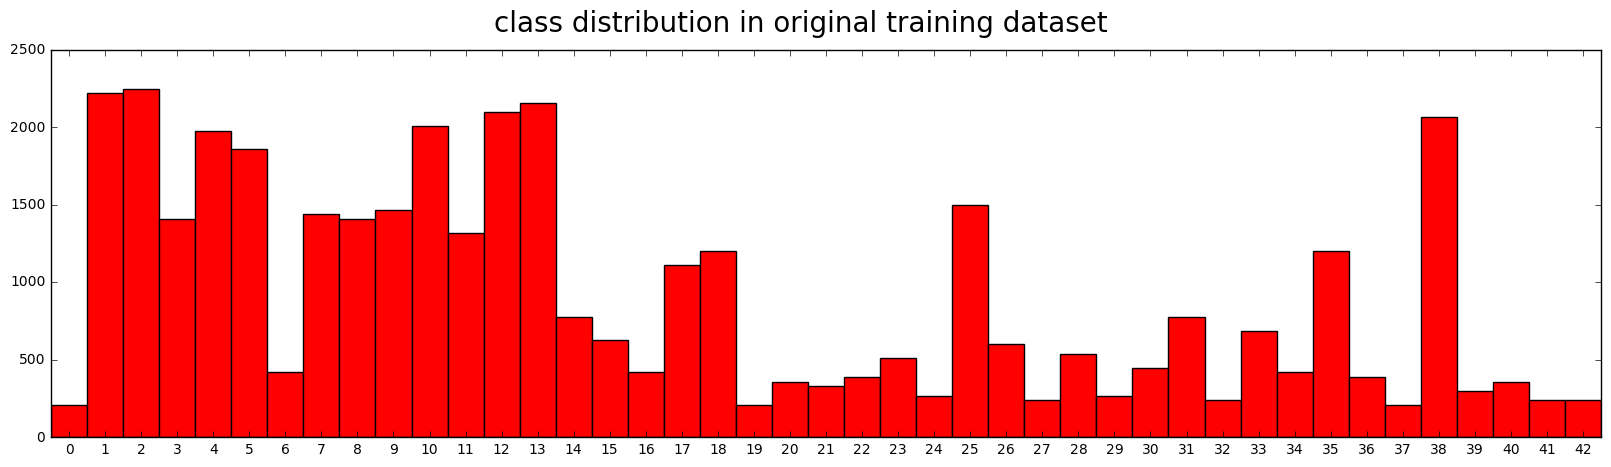

In [5]:
# visualize the distribution of 43 traffic signs with frequency bar chart

frequencies = np.bincount(y_train)
signID = np.nonzero(frequencies)[0]
# np.vstack((ii,y[ii])).T
pos = np.arange(len(signID))
width = 1.0     # gives histogram aspect to the bar diagram

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(signID)
plt.bar(pos, frequencies, width, color='r')
fig.suptitle("class distribution in original training dataset",fontsize=20)
plt.show()

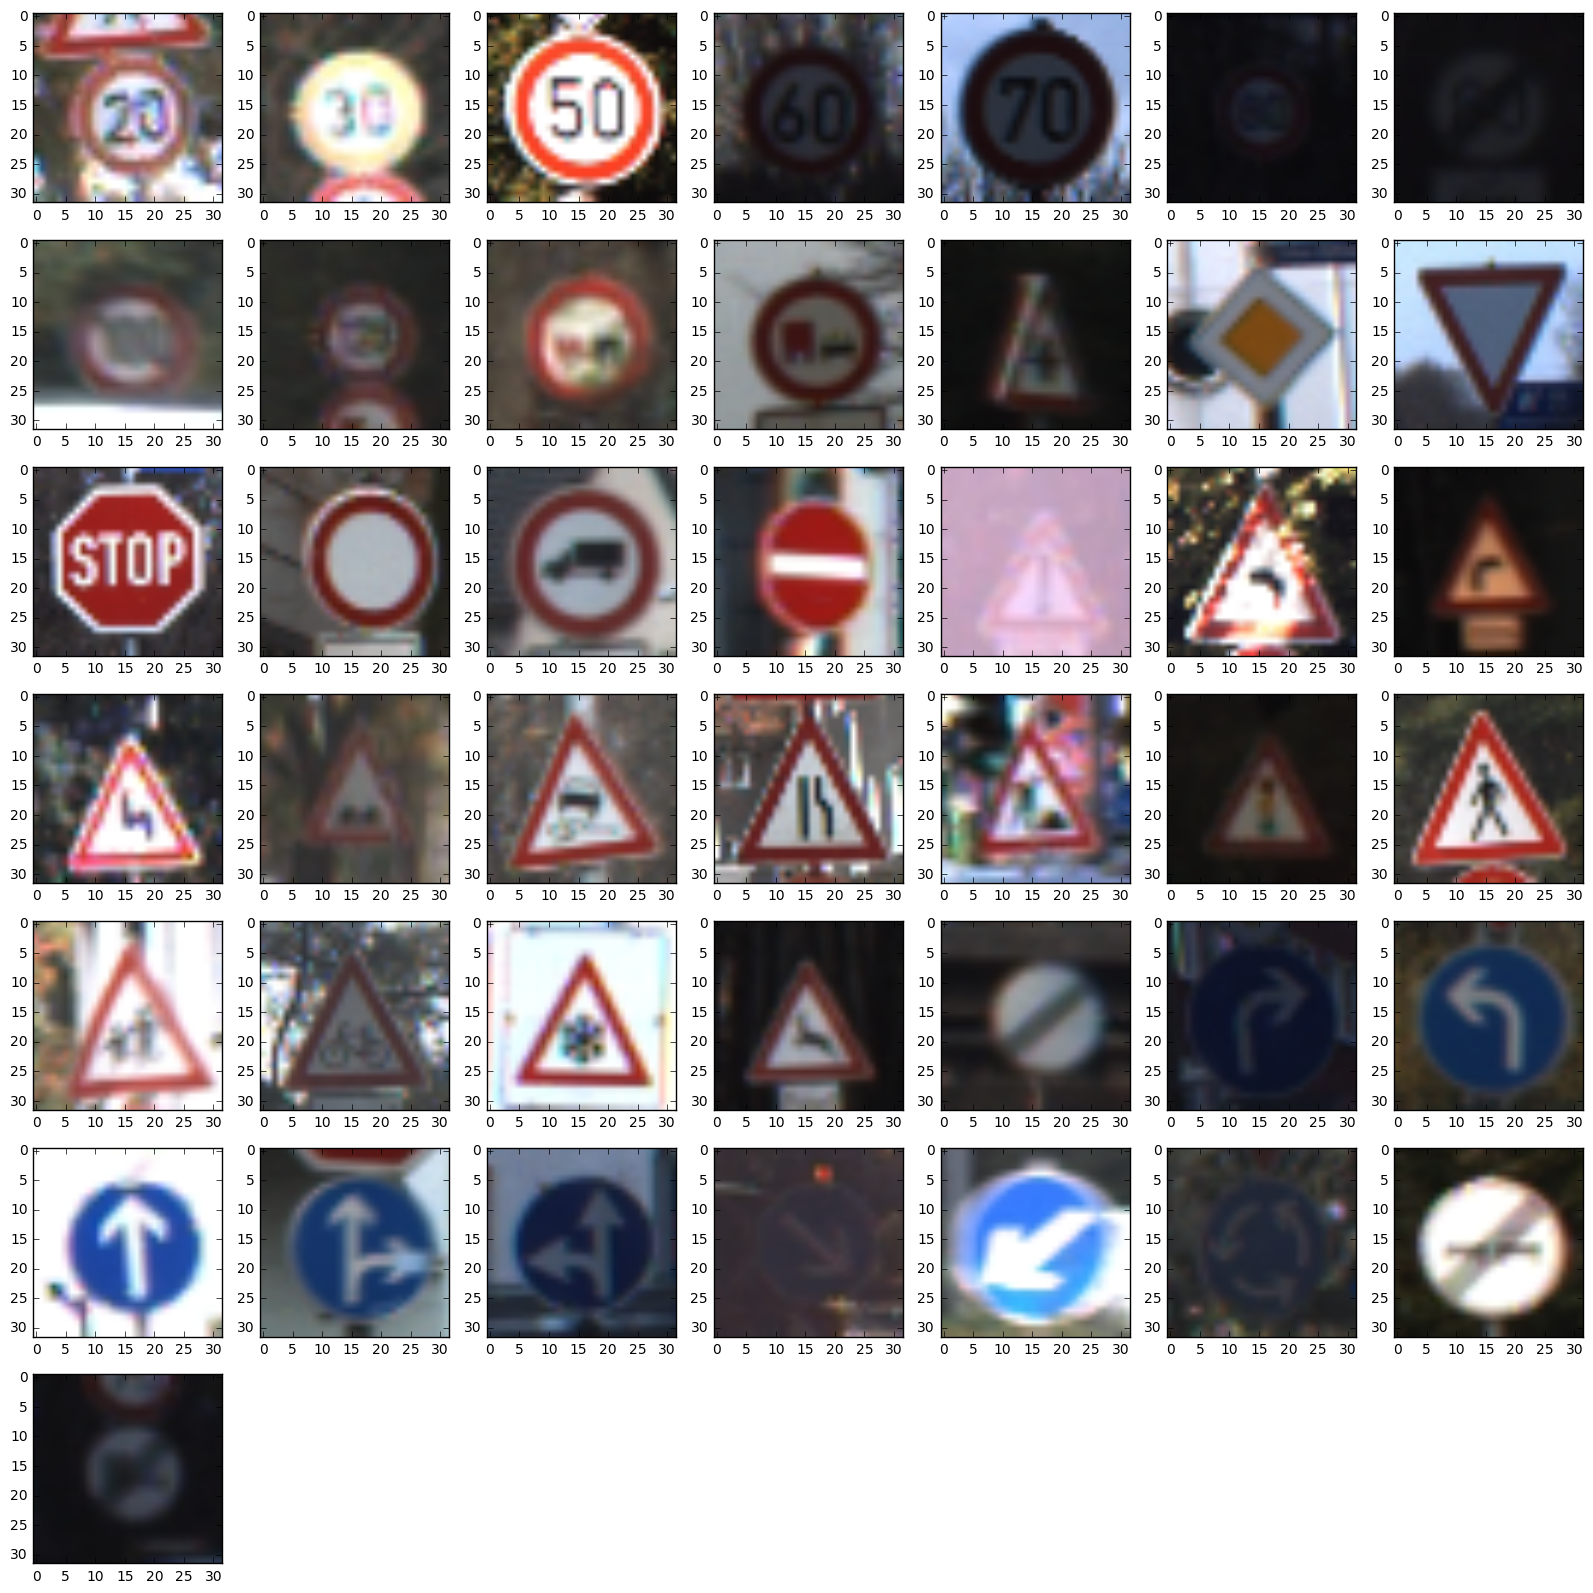

In [6]:
# visualize 1 random traffic sign in each of the 43 traffic sign categories
# On the top left corner is class 1, and the class of traffic signs increases horizontally then vertically.
from matplotlib import gridspec

unq, unq_inv, unq_cnt = np.unique(y_train, return_inverse=True, return_counts=True)
ids = np.split(np.argsort(unq_inv), np.cumsum(unq_cnt[:-1]))

fig = plt.figure(figsize=(20,20))
for i in range(len(ids)):
    subindex = random.randint(0, len(ids[i])-1)
    index = ids[i][subindex]
    image = X_train[index].squeeze()
    plt.subplot(7,7,i+1)
    plt.imshow(image)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these. (This paper feed the features from all different stages to the final output layer. All images are down-sampled or upsampled to 32x32 (dataset samples sizes vary from 15x15 to 250x250) and converted to YUV space. The Y channel is then preprocessed with global and local contrast normalization while U and V channels are left unchanged. Global normalization first centers each image around its mean value, whereas local normalization (see II-B) emphasizes edges. Additionally, we build a jittered dataset by adding 5 transformed versions of the original training set.  Samples are randomly perturbed in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees))

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

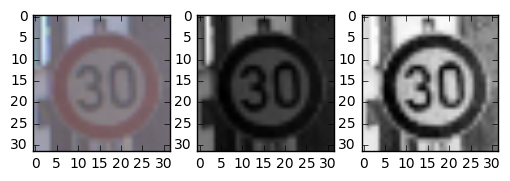

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# step 1
# change to gray scale, then sharp the image
# step 1.1
# random select 1 image and visualize the difference

import cv2
index = random.randint(0, len(X_train)-1)
# index = 24829 # this one shows a perfect example
image_original=X_train[index]
image_grayscale=cv2.cvtColor(image_original, cv2.COLOR_BGR2YUV)
image_grayscale=image_grayscale[:,:,0]
image_sharpened = cv2.equalizeHist(image_grayscale)
plt.subplot(1,3,1)
plt.imshow(image_original)
plt.subplot(1,3,2)
plt.imshow(image_grayscale,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_sharpened,cmap='gray')

In [8]:
# step 1.2 grayscale, sharp and z-sore all samples

def gray_sharp_zscore(image):
    image_original=image
    image_grayscale=cv2.cvtColor(image_original, cv2.COLOR_BGR2YUV)
    image_grayscale=image_grayscale[:,:,0]
    image_sharpened = cv2.equalizeHist(image_grayscale)
    image_zscore = (image_sharpened-np.mean(image_sharpened))/np.std(image_sharpened)
    image_zscore = image_zscore.reshape(image_zscore.shape+(1,))
    return image_zscore
    
train_sharpgray = []
test_sharpgray = []
for i in range(len(X_train)):
    train_sharpgray.append(gray_sharp_zscore(X_train[i]))
X_train = np.asarray(train_sharpgray)
for i in range(len(X_test)):
    test_sharpgray.append(gray_sharp_zscore(X_test[i]))
X_test = np.asarray(test_sharpgray)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocessed the data in 3 steps:

1. convert to grayscale
        I believe the shape should not be the main factor to detect a traffic sign rather than color. If the color of a traffic sign fade, one should still be able to tell what it is. And using gray color should also help to make the model more transferable. For example, in german the "keep right" sign has a blue background but in US it may just be black and white. So in such case, the model should still work. Also in Pierre Sermanet and Yann LeCun's paper, they reported that grayscale images perform better than color images. I tried both BRG2GRAY and BGR2YUV then only use Y channel, both ways perform similar. And here I used BGR2YUV then use only Y channel.
        
2. Sharp the image by histogram equalization
        Sometimes because of the low luminance the image has every low contrast. Use histogram equalization and increase the contrast and make the image more readable.
        
3. z-core the image by substracting mean and devided standard deviation
        I personally feel like it is always good to normalize the data.


In [9]:
### Generate additional data
## define a jittering function
def jitter(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,cha = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    img = img.reshape((rows,cols,cha))
    
    return img

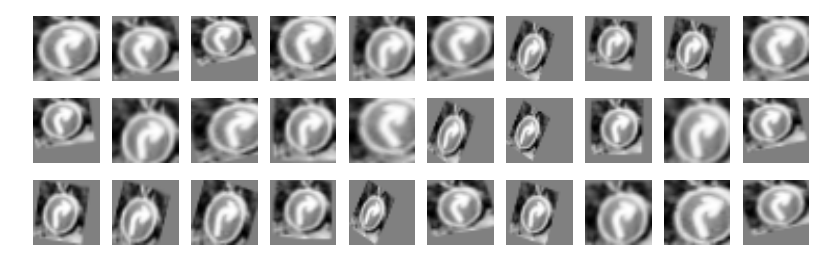

In [10]:
# visualize jittered images
index = random.randint(0, len(X_train)-1)
image = X_train[index]
gs1 = gridspec.GridSpec(3, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(10,3))
for i in range(30):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = jitter(image,20,10,5)

    plt.subplot(3,10,i+1)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.axis('off')

plt.show()

In [11]:
def jitterall(ids,frequencies):
    jitternum = np.floor((np.max(frequencies)-frequencies)/frequencies)
    jitternum = jitternum.astype(int)
    jitteredsamples = []
    jitteredlabels = []
    for i in range(len(jitternum)):
        if jitternum[i]>0:
            for j in range(frequencies[i]):
                for k in range(jitternum[i]):
                    jitteredsamples.append(jitter(X_train[ids[i][j]],20,10,5))
                    jitteredlabels.append(y_train[ids[i][j]])
    jitteredsamples = np.asarray(jitteredsamples)
    jitteredlabels = np.asarray(jitteredlabels)
    return jitteredsamples, jitteredlabels

def jitterpart(ids,frequencies):
    jitterprob = (np.max(frequencies)-frequencies)/frequencies
    jitteredsamples = []
    jitteredlabels = []
    for i in range(len(jitterprob)):
        if jitterprob[i]>0:
            for j in range(frequencies[i]):
                thresh=random.uniform(0, 1)
                if thresh<jitterprob[i]:
                    jitteredsamples.append(jitter(X_train[ids[i][j]],20,10,5))
                    jitteredlabels.append(y_train[ids[i][j]])
    jitteredsamples = np.asarray(jitteredsamples)
    jitteredlabels = np.asarray(jitteredlabels)
    return jitteredsamples, jitteredlabels

# jitter training set
jitteredsamples, jitteredlabels = jitterall(ids,frequencies)
X_train=np.concatenate((X_train, jitteredsamples), axis=0)
y_train=np.concatenate((y_train, jitteredlabels), axis=0)

In [12]:
# jitter training set again
unq, unq_inv, unq_cnt = np.unique(y_train, return_inverse=True, return_counts=True)
ids = np.split(np.argsort(unq_inv), np.cumsum(unq_cnt[:-1]))
frequencies = np.bincount(y_train)

jitteredsamples, jitteredlabels = jitterpart(ids,frequencies)
X_train=np.concatenate((X_train, jitteredsamples), axis=0)
y_train=np.concatenate((y_train, jitteredlabels), axis=0)

In [13]:
### and split the data into training/validation/testing sets here.
# split the given training set, 80% into a training set and 20% into a validation set

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("number of training samples: {}".format(X_train.shape[0]))
print("number of validation samples: {}".format(X_validation.shape[0]))
print("number of test samples: {}".format(X_test.shape[0]))

number of training samples: 77364
number of validation samples: 19342
number of test samples: 12630


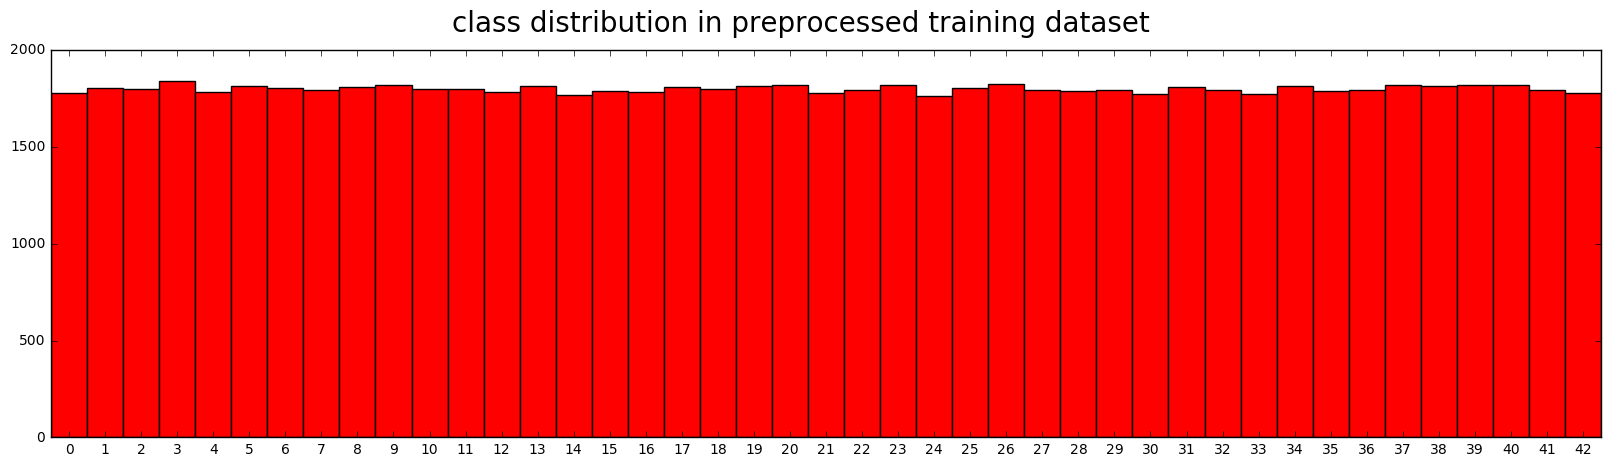

In [14]:
# class distribution of preprocess training set
frequencies = np.bincount(y_train)
signID = np.nonzero(frequencies)[0]
pos = np.arange(len(signID))
width = 1.0     # gives histogram aspect to the bar diagram
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(signID)
plt.bar(pos, frequencies, width, color='r')
fig.suptitle("class distribution in preprocessed training dataset",fontsize=20)
plt.show()

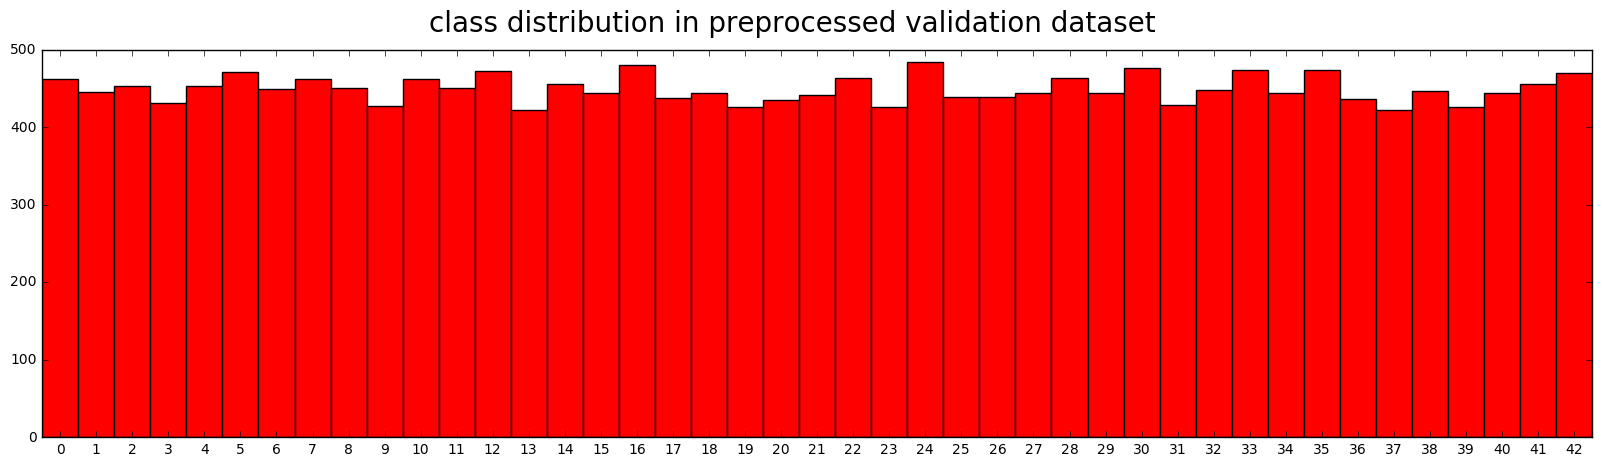

In [15]:
# class distribution of preprocess validation set
frequencies = np.bincount(y_validation)
signID = np.nonzero(frequencies)[0]
pos = np.arange(len(signID))
width = 1.0     # gives histogram aspect to the bar diagram
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(signID)
plt.bar(pos, frequencies, width, color='r')
fig.suptitle("class distribution in preprocessed validation dataset",fontsize=20)
plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. generate more data
        From the frequency bar chart in the visualization section we can see the data is unbalanced across classes. So in order to balance the data, I generate additional data samples by jittering the original image. The jittering is conducted by applying affine transformations (such as rotations, translations and shearing). Affine transformations are transformations where the parallel lines before transformation remain parallel after transformation.

2. split into train and validation
        80% traning set with about 77524 samples, 20% validation set with about 19381 samples, and 12630 test samples. Because of the random process in the jitter function, the number of training samples and the number of validation samples may vary a little.

In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Introduce dropout in layers with too many weights.
### Introduce L2 regularization to prevent having large weights.


import tensorflow as tf
from tensorflow.contrib.layers import flatten

def WhichSign(x, droprate=tf.constant(0.5)):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6],mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    layer1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID')
    layer1 = tf.nn.bias_add(layer1, b1)
    
    # TODO: Activation.
    layer1 = tf.nn.relu(layer1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1 = tf.nn.max_pool(layer1,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID')
    #layer1 = tf.nn.dropout(layer1,droprate)

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    w2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16],mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    layer2 = tf.nn.conv2d(layer1, w2, strides=[1, 1, 1, 1], padding='VALID')
    layer2 = tf.nn.bias_add(layer2, b2)
    
    # TODO: Activation.
    layer2 = tf.nn.relu(layer2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = tf.nn.max_pool(layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    #layer2 = tf.nn.dropout(layer2,droprate)

    # TODO: Layer 3: Convolutional. Output = 3x3x32.
    w3 = tf.Variable(tf.truncated_normal([3, 3, 16, 32],mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(32))
    layer3 = tf.nn.conv2d(layer2, w3, strides=[1, 1, 1, 1], padding='VALID')
    layer3 = tf.nn.bias_add(layer3, b3)
    
    
    
    # TODO: Flatten. Input = 5x5x16. Output = 400+294.
    layer1 = tf.nn.max_pool(layer1,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID')
    layer1_flatten = tf.contrib.layers.flatten(layer1)
    layer2_flatten = tf.contrib.layers.flatten(layer2)
    layer3_flatten = tf.contrib.layers.flatten(layer3)
    layer3_flatten = tf.concat(1,[layer1_flatten,layer2_flatten,layer3_flatten])
    
    # TODO: Layer 3: Fully Connected. Input = 400+294+288=982. Output = 120.
    w4 = tf.Variable(tf.truncated_normal([982,120],mean=mu,stddev=sigma))
    b4 = tf.Variable(tf.zeros(120))
    layer4 = tf.add(tf.matmul(layer3_flatten,w4),b4)
    
    # TODO: Activation.
    layer4 = tf.nn.relu(layer4)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    w5 = tf.Variable(tf.truncated_normal([120,84],mean=mu,stddev=sigma))
    b5 = tf.Variable(tf.zeros(84))
    layer5 = tf.add(tf.matmul(layer4,w5),b5)
    
    # TODO: Activation.
    layer5 = tf.nn.relu(layer5)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    w6 = tf.Variable(tf.truncated_normal([84,43],mean=mu,stddev=sigma))
    b6 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(layer5,w6),b6)
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I borrowed some ideas from both Pierre Sermanet and Yann LeCun's paper and LeNet. My network has 3 covolutinonal layers and 3 fully connected layers.

1st layer: convolutional, input 32x32x1, output 28x28x6, maxpull, output 14x14x6

2nd layer: convolutional, input 14x14x6, output 10x10x16, maxpull, output 5x5x16

3rd layer: convolutional, input 5x5x16, output 3x3x32

flatten: here I concatinate output from all 1st, 2nd and 3rd layer and input them to the next fully connected layer. This is the idea borrowed from Pierre Sermanet and Yann LeCun's paper. To reduce the feature size, output from 1st layer are maxpulled again. So in total, 7x7x6 = 294 features from 1st layer, 5x5x16 = 400 features from 2nd layer and 3x3x32 = 288 features from 3rd layer are concatinated together.

4th layer: fully connected, input 982 output 120

5th layer: fully connected, input 120 output 84

6th layer: fully connected, input 84 output 43




In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = WhichSign(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
trainable_vars = tf.trainable_variables()
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in trainable_vars]) * 0.001
# Include L2 loss plus cross entropy instead of cross entropy alone.
loss_operation = tf.reduce_mean(cross_entropy + l2_loss) 
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



EPOCHS = 500
BATCH_SIZE = 512

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [18]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables()) # tf.global_variables_initializer  
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'TrafficSign.ckpt')
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.550

EPOCH 2 ...
Validation Accuracy = 0.657

EPOCH 3 ...
Validation Accuracy = 0.709

EPOCH 4 ...
Validation Accuracy = 0.756

EPOCH 5 ...
Validation Accuracy = 0.785

EPOCH 6 ...
Validation Accuracy = 0.803

EPOCH 7 ...
Validation Accuracy = 0.813

EPOCH 8 ...
Validation Accuracy = 0.823

EPOCH 9 ...
Validation Accuracy = 0.836

EPOCH 10 ...
Validation Accuracy = 0.849

EPOCH 11 ...
Validation Accuracy = 0.846

EPOCH 12 ...
Validation Accuracy = 0.844

EPOCH 13 ...
Validation Accuracy = 0.848

EPOCH 14 ...
Validation Accuracy = 0.855

EPOCH 15 ...
Validation Accuracy = 0.865

EPOCH 16 ...
Validation Accuracy = 0.869

EPOCH 17 ...
Validation Accuracy = 0.879

EPOCH 18 ...
Validation Accuracy = 0.876

EPOCH 19 ...
Validation Accuracy = 0.878

EPOCH 20 ...
Validation Accuracy = 0.883

EPOCH 21 ...
Validation Accuracy = 0.879

EPOCH 22 ...
Validation Accuracy = 0.885

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used Adam optimizer,

with batch size = 512
learning rate = 0.001
epochs = 500

It takes about 16 min to train using 4 Geforce GTX TITAN X

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I have tried:

1. add a l2 normalizer to the objective function
2. try less epoches
3. different batch sizes
4. use dropout

It has not much difference but I decided to add a l2 normalizer to the objective function
Different bath sizes don't impact the accuracy much
The more epoches the better but obviously more time needed
Dropout will decrease the validation accuracy with the same training epoches a lot. I may take a much longer time to train the network with dropout to reach the same accuracy. Since I feel there is not much concerns of overfitting in this problem I decided not to use dropout.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
# first test on the given test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.930


In [20]:
### Name of new test images from website
### Feel free to use as many code cells as needed.

import PIL
from PIL import Image
import matplotlib.image as mpimg
import os
import cv2

def resize_preprocess(image,width_new=32,hight_new=32):
    img = image.resize((width_new,hight_new), Image.ANTIALIAS)
    img = np.asarray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = gray_sharp_zscore(img)
    img = img.reshape((1,)+img.shape)
    return img
    
TestImages=os.listdir("TrafficSignsFromWeb/")
for testImage in TestImages:
    if not(testImage.endswith(".png")):
        TestImages.remove(testImage)
print(TestImages)

['Screen Shot 2017-01-26 at 2.50.52 PM.png', 'Screen Shot 2017-01-23 at 11.26.59 AM.png', 'Screen Shot 2017-01-26 at 2.50.04 PM.png', 'Screen Shot 2017-01-23 at 11.28.26 AM.png', 'Screen Shot 2017-01-26 at 2.51.54 PM.png', 'Screen Shot 2017-01-26 at 2.54.02 PM.png', 'Screen Shot 2017-01-26 at 2.50.19 PM.png', 'Screen Shot 2017-01-26 at 2.53.45 PM.png', 'Screen Shot 2017-01-26 at 2.54.21 PM.png', 'Screen Shot 2017-01-27 at 10.35.00 AM.png', 'Screen Shot 2017-01-27 at 10.30.43 AM.png', 'Screen Shot 2017-01-26 at 2.55.17 PM.png', 'Screen Shot 2017-01-26 at 2.55.25 PM.png', 'Screen Shot 2017-01-26 at 2.53.05 PM.png', 'Screen Shot 2017-01-27 at 10.30.39 AM.png']


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I have plotted the images below in the "softmax probability" section. I tested on 15 images found from internet. 11 of them are german traffic signs and I expect my model to classify them right. But still these 11 samples can be tricky to my model: 1 sign is halfly cover by snow and 1 sign is a picture not a real physical sign. Other than the 11 signs, 2 are chinese stop sign and yeild sign, 1 is US speed limit sign, 1 is 130km/h german speed limit sign which is not in the trained 43 classes. For these images I want to see how my model gona classify them

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
raw_logits = []
print('identified classes are:')
with tf.Session() as sess:
    saver.restore(sess, './'+"TrafficSign.ckpt") #tf.train.latest_checkpoint('.')
    for testImage in TestImages:
        image = Image.open('TrafficSignsFromWeb/'+testImage)
        image = resize_preprocess(image)
        rawlogits = sess.run(logits, feed_dict={x: image})
        raw_logits.append(rawlogits)
        print(tf.argmax(rawlogits,1).eval())
print('Clearer results are shown in the next section')

identified classes are:
[38]
[14]
[3]
[13]
[41]
[32]
[11]
[8]
[10]
[14]
[21]
[18]
[28]
[19]
[40]
Clearer results are shown in the next section


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

For the German signs, my model correctly classified 8 out of 11 which is 73% accuracy. The test accuary is 93% on the given test set as shown in the cell several blocks above. So the model performans a little bit worse on captured pictures when compared to testing on the given test data set. It is reasonable because the captured images have every different quality campared to the training and testing samples (come from a totally different distribution). But I think there are some ways to enhence the model's tranferability such as using dropouts while increasing training time, generating extra training samples and using different network structures.

The 3 errors in the 15 new images are: 

1. the one is not a phsical sign. This at least shows a real pysical sign looks different to a picture of sign in my models's eyes... 

2. the 30km/h speed limit sign. This photo is taken kind of from right under the sign so the large angle may cause the error. I think by increasing the angle range when creating the additional jittered training samples may help. 

3. the ice/snow sign. Model give the second highest confidence to the right class but still it is an error.

Suprisingly, the sign halfly covered by snow didn't give the model any problem. 

For the non-German signs, the model classify the 130km/h as 12km/h which I will say it did pretty good.

The model totally missed the US 45mph speed limit sign, because both the number and shape are very different from the training samples.

The model give the second highest confidence to the correct class for both the two Chinese signs which is not bad.


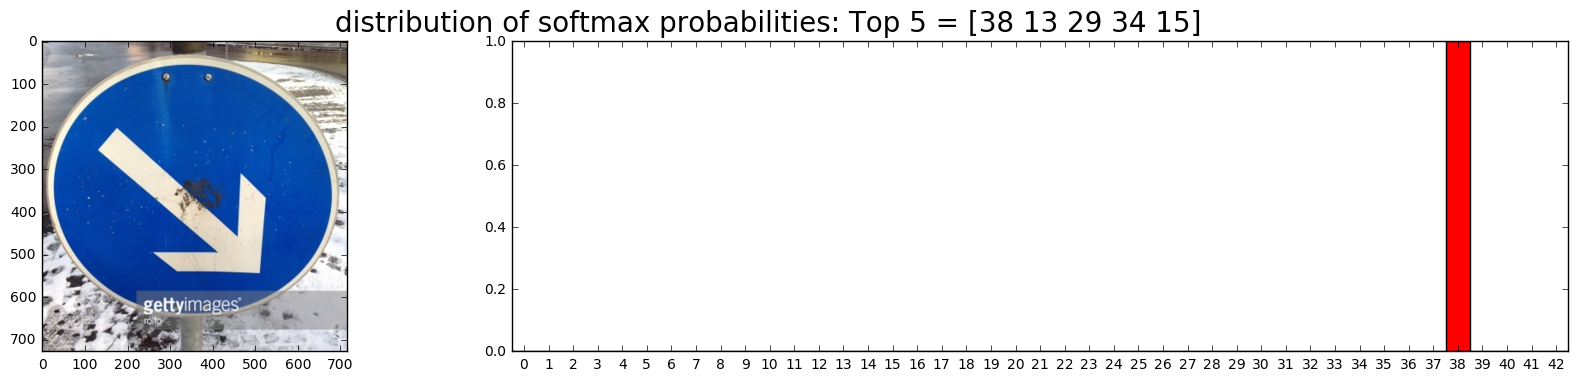

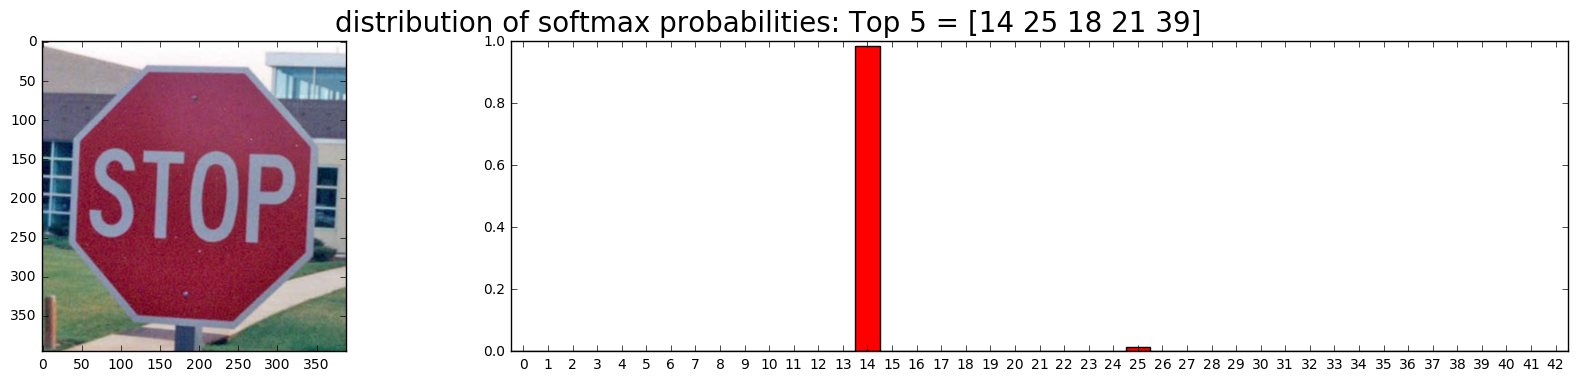

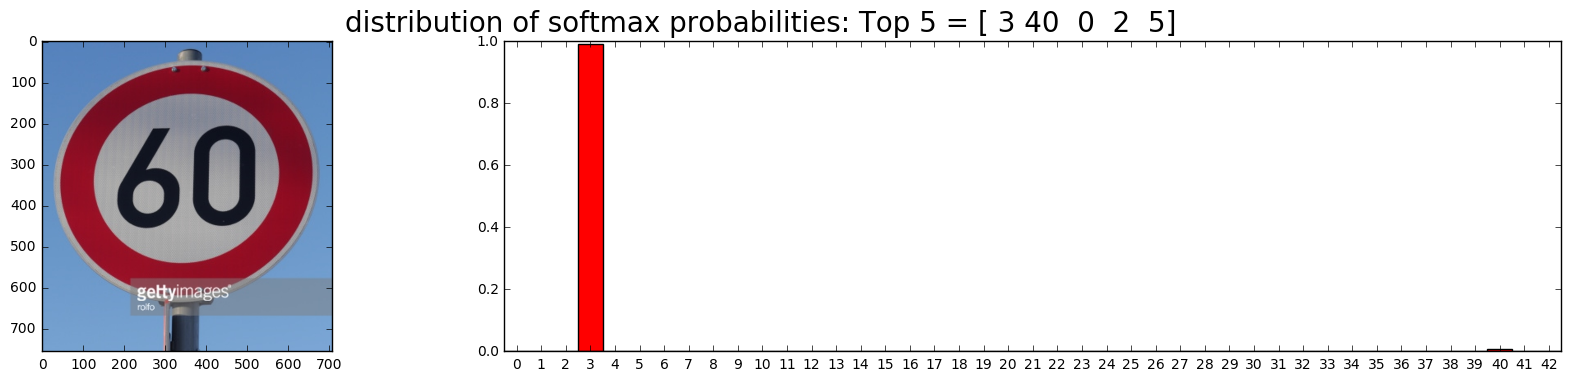

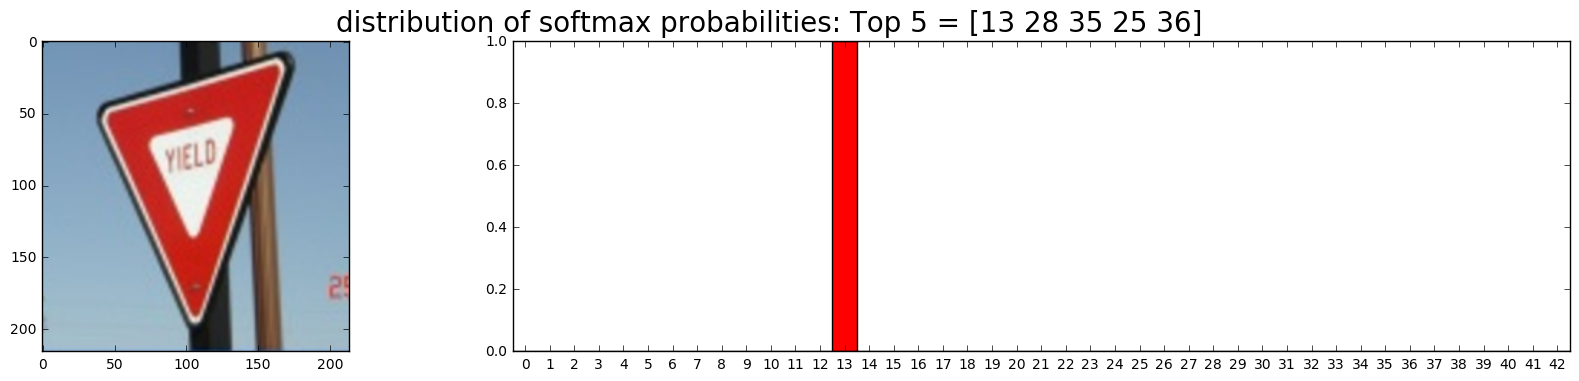

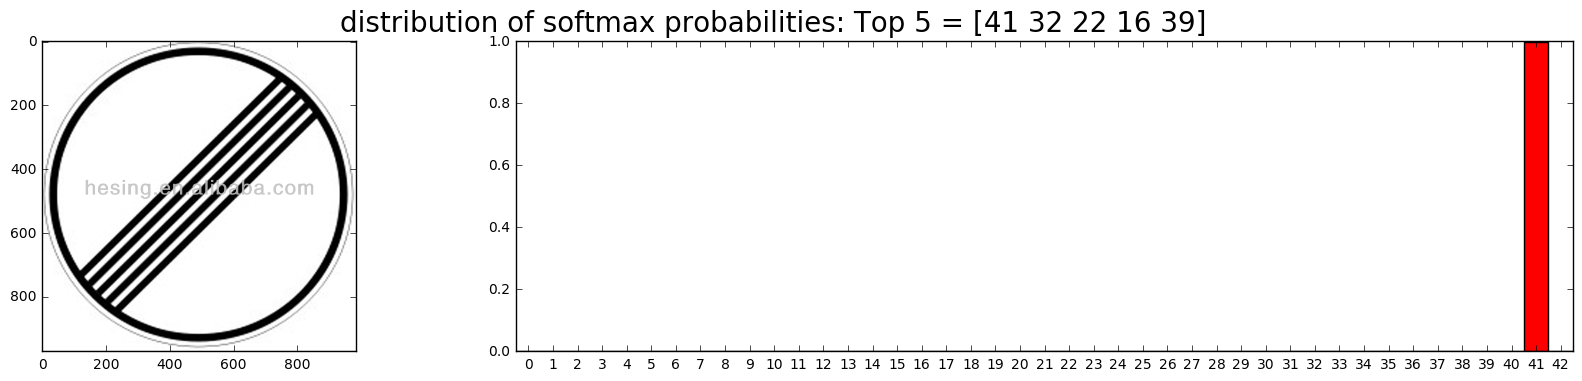

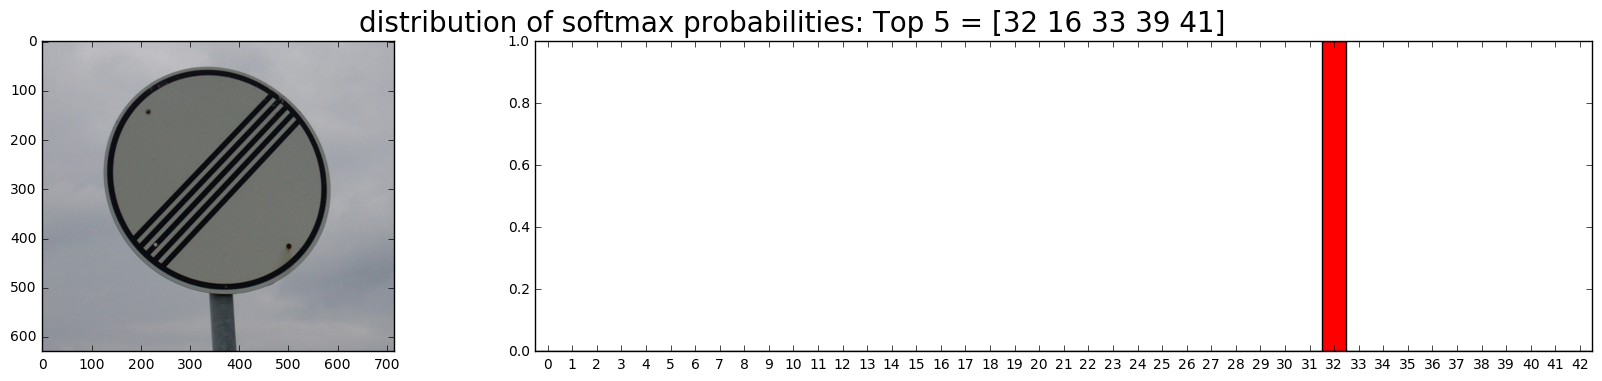

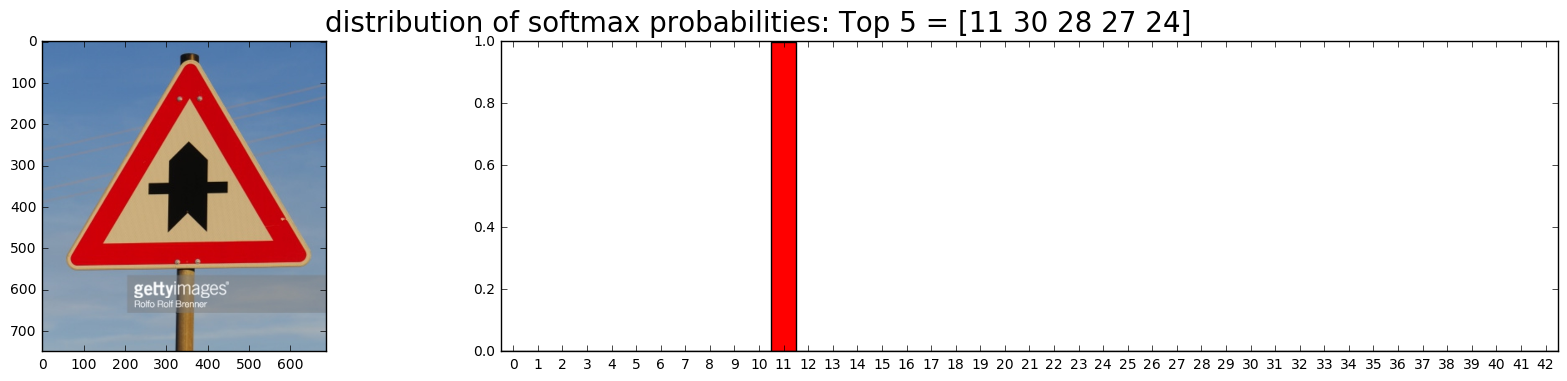

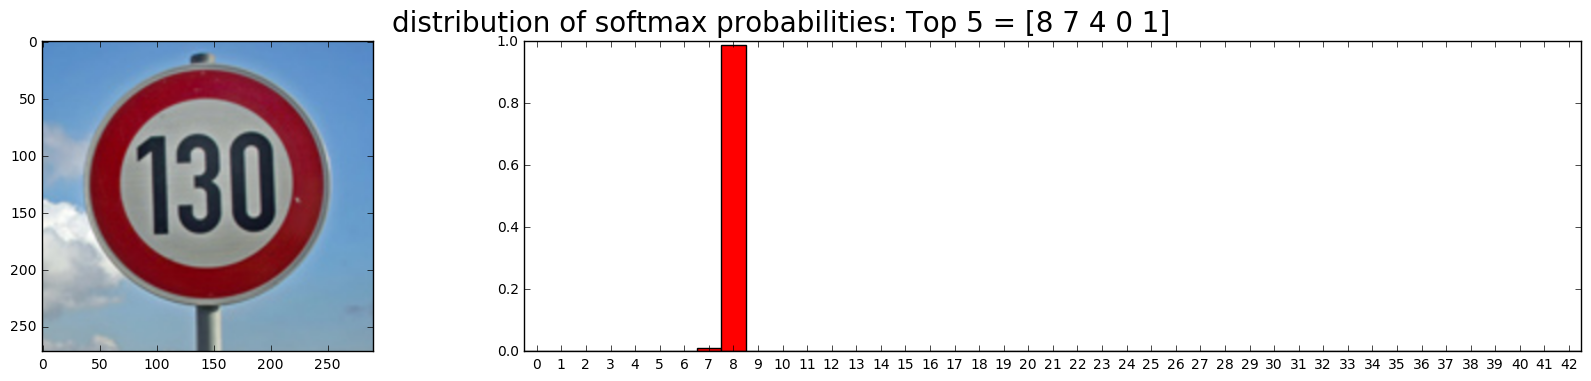

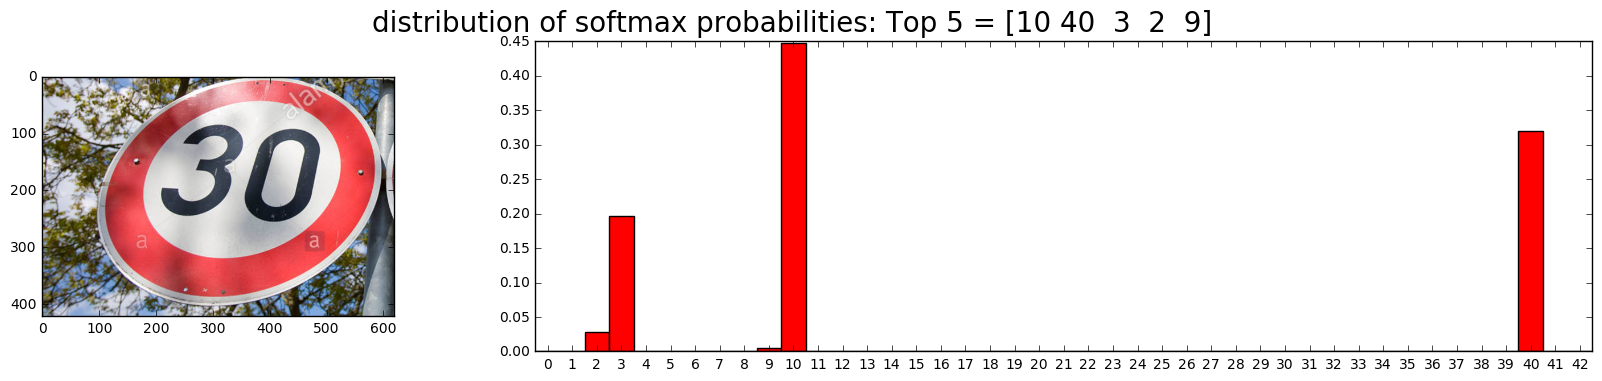

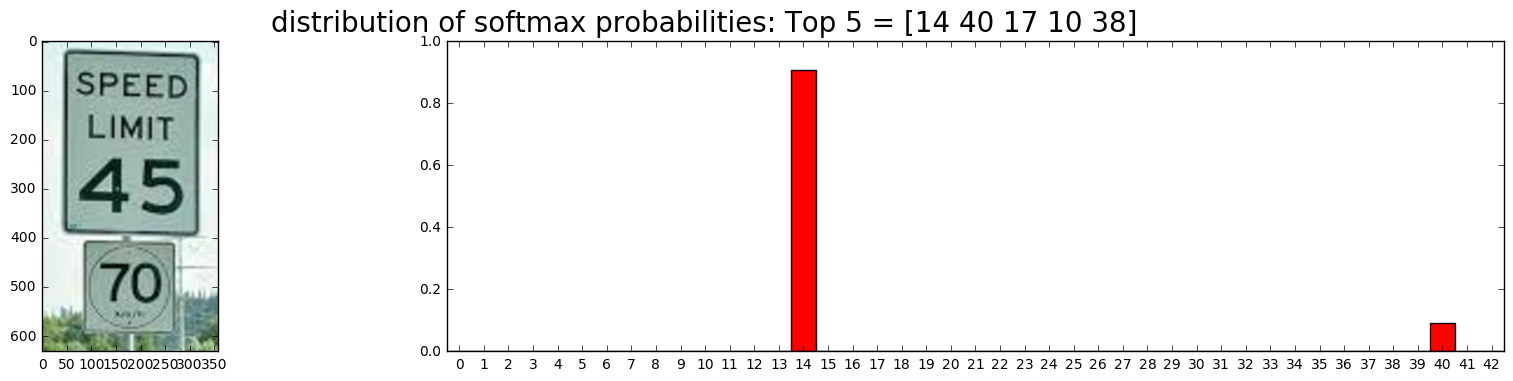

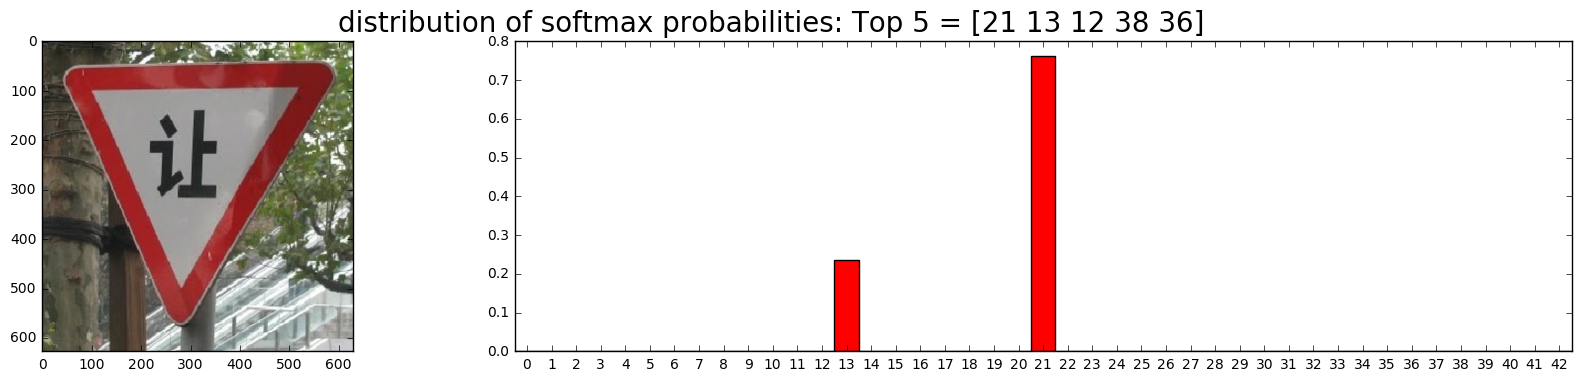

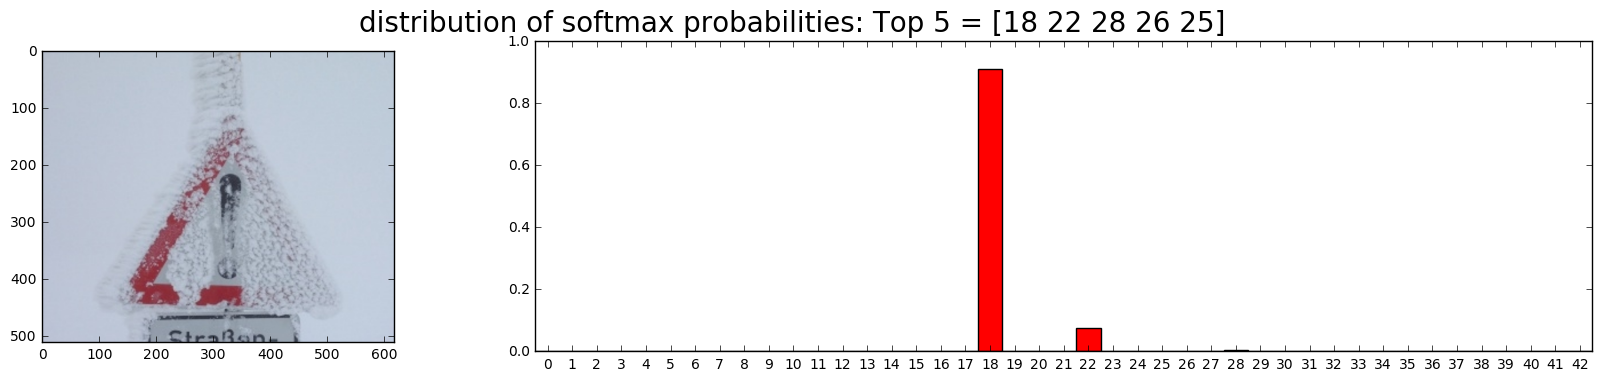

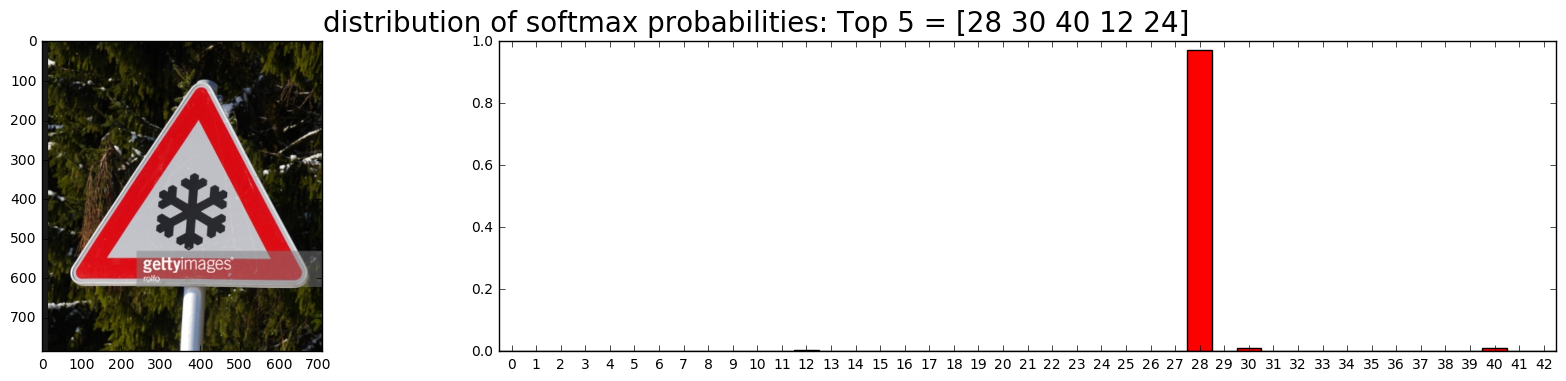

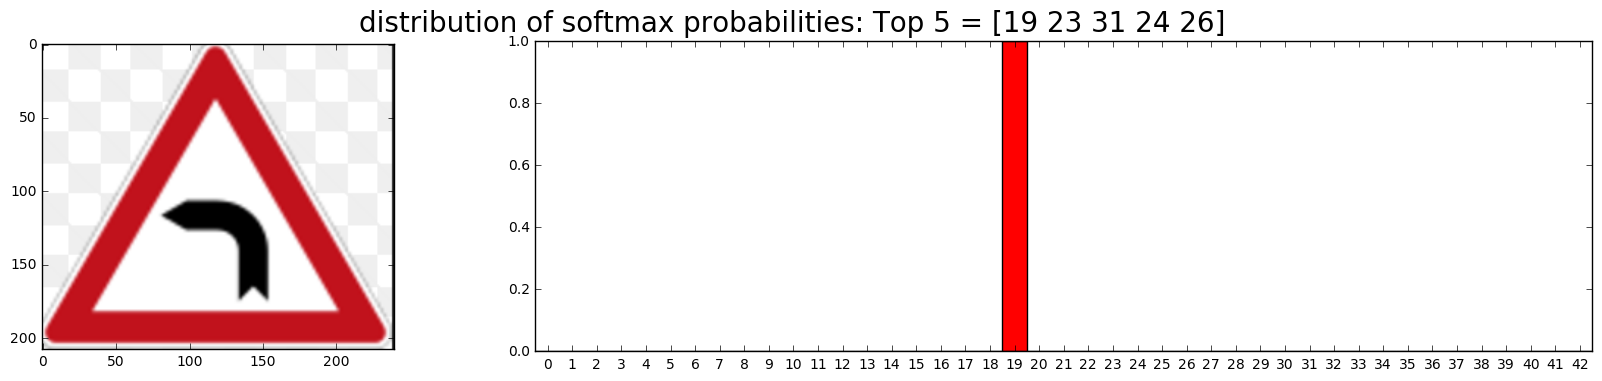

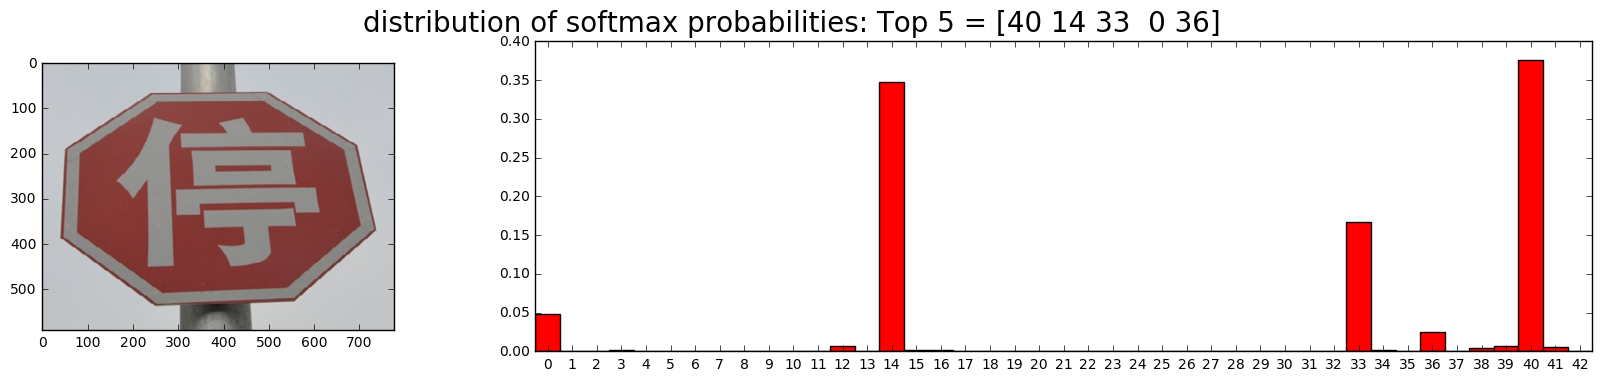

In [22]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)
for i in range(len(raw_logits)):
    
    image = Image.open('TrafficSignsFromWeb/'+TestImages[i])
    
    frequencies = softmax(raw_logits[i])
    frequencies = frequencies.reshape((43))
    pos = np.arange(len(frequencies))
    width = 1.0     # gives histogram aspect to the bar diagram

    
    fig = plt.figure(figsize=(20, 4)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0])
    plt.imshow(image)
    ax1 = plt.subplot(gs[1])
    ax1.set_xticks(pos + (width / 2))
    ax1.set_xticklabels(signID)
    plt.bar(pos, frequencies, width, color='r')
#    plt.tight_layout()
    with tf.Session() as sess:
        k = sess.run(tf.nn.top_k(tf.constant(raw_logits[i]), k=5))
        
    fig.suptitle('distribution of softmax probabilities: Top 5 = {}'.format(k.indices[0]), fontsize=20)
    
    plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The above figures show the softmax probabilities of each of the 15 captured images. And the 5 classes with top probabilities are dispalyed in order in the figure titles.
From the figures we can see:
1. The model are pretty confident with those correctly predicted images (with >99% certainty)
2. The sign halfly covered by snow decreases model's certainty, but the model still managed to make it right.
3. For the fake sign (not physical one), the model was nearly 100% certain it belongs to another class......
4. The model was confused by the ill-angled 30km/h sign...
5. For the two Chinese signs, the model was not certain and gave the correct class a 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.